##Installing transformers

In [1]:
!pip install torch transformers datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 47.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.7/468.7 kB 19.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 25.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 kB 9.0 MB/s eta 0:00:00


## Importing libraries

In [2]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset, random_split
from transformers import BertTokenizer, BertForSequenceClassification
from datasets import load_dataset
import os
import pandas as pd
from sklearn.metrics import f1_score
import time
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle


Loading the IMDb dataset

In [3]:
imdb_dataset = load_dataset("imdb")


Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset imdb downloaded and prepared to /root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

##Getting the tokenizer and model

In [4]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased",do_lower_case=True)
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", num_labels=2, output_attentions=True)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

##IMDB Dataset class

In [11]:
class IMDBDataset(Dataset):
    def __init__(self, dataset, tokenizer, max_length):
        self.dataset = dataset
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        text = self.dataset[idx]['text']
        label = self.dataset[idx]['label']
        tokens = self.tokenizer.encode_plus(
            text,
            truncation=True,
            max_length=self.max_length,
            padding="max_length",
            return_tensors="pt"
        )
        return {
            "input_ids": tokens["input_ids"].squeeze(),
            "attention_mask": tokens["attention_mask"].squeeze(),
            "label": torch.tensor(label)
        }

##Initializing model

In [12]:
# Set the maximum length of words to 256 to save memory
max_length = 256
batch_size = 16

train_size = int(0.8 * len(imdb_dataset["train"]))
val_size = len(imdb_dataset["train"]) - train_size

train_dataset, val_dataset = random_split(
    IMDBDataset(imdb_dataset["train"], tokenizer, max_length),
    [train_size, val_size]
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(IMDBDataset(imdb_dataset["test"], tokenizer, max_length), batch_size=batch_size)

## Training model

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available())
torch.cuda.empty_cache()
model.to(device)

epochs = 10
lr = 2e-5
optimizer = optim.AdamW(model.parameters(), lr=lr)
loss_function = nn.CrossEntropyLoss()
loss_list=[]
start_time = time.time()

for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss

        total_loss += loss.item()
        loss.backward()
        optimizer.step()

    avg_train_loss = total_loss / len(train_loader)
    print(f"EPOCH {epoch + 1}:")
    print(f"Train loss: {round(avg_train_loss, 4)}, Running time: {round(time.time() - start_time, 4)} seconds")
    loss_list.append(avg_train_loss)
    print()

training_time = time.time() - start_time
print(f"Training time: {training_time:.2f} seconds")

True
EPOCH 1:
Train loss: 0.2776, Running time: 937.9071 seconds

EPOCH 2:
Train loss: 0.15, Running time: 1871.2713 seconds

EPOCH 3:
Train loss: 0.0744, Running time: 2803.7287 seconds

EPOCH 4:
Train loss: 0.0431, Running time: 3735.8845 seconds

EPOCH 5:
Train loss: 0.0319, Running time: 4669.2118 seconds

EPOCH 6:
Train loss: 0.0222, Running time: 5602.0351 seconds

EPOCH 7:
Train loss: 0.0188, Running time: 6534.7207 seconds

EPOCH 8:
Train loss: 0.0182, Running time: 7465.4895 seconds

EPOCH 9:
Train loss: 0.0126, Running time: 8396.1724 seconds

EPOCH 10:
Train loss: 0.013, Running time: 9328.1034 seconds

Training time: 9328.10 seconds


##Gather accuracy and F1 score

In [14]:
model.eval()

correct_predictions = 0
total_predictions = 0
true_labels = []
predicted_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        
        _, predicted = torch.max(logits, 1)

        correct_predictions += (predicted == labels).sum().item()
        total_predictions += labels.size(0)

        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

accuracy = correct_predictions / total_predictions
f1 = f1_score(true_labels, predicted_labels, average='binary')
print(f"Test Accuracy: {accuracy * 100:.2f}%, F1 Score: {f1:.4f}")


Test Accuracy: 90.98%, F1 Score: 0.9132


##1xN attention matrix for correct and incorrect exampeles

In [22]:
correct_examples = []
incorrect_examples = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        _, predicted = torch.max(logits, 1)

        for i, (true_label, pred_label) in enumerate(zip(labels, predicted)):
            if len(correct_examples) >= 5 and len(incorrect_examples) >= 5:
                break

            if true_label == pred_label and len(correct_examples) < 5:
                correct_examples.append(
                    tokenizer.decode(input_ids[i], skip_special_tokens=True)
                )
            elif true_label != pred_label and len(incorrect_examples) < 5:
                incorrect_examples.append(
                    tokenizer.decode(input_ids[i], skip_special_tokens=True)
                )

        if len(correct_examples) >= 5 and len(incorrect_examples) >= 5:
            break


In [23]:
def get_sequence(text, model, tokenizer, layer_idx, head_idx):
    tokens = tokenizer.encode_plus(
        text,
        truncation=True,
        max_length=50,
        return_tensors="pt"
    )
    input_ids = tokens["input_ids"].to(device)
    attention_mask = tokens["attention_mask"].to(device)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)

    attentions = outputs.attentions[layer_idx][0, head_idx].cpu().numpy()
    mean_attention_scores = np.mean(attentions, axis=0, keepdims=True)
    norm_as = (mean_attention_scores - np.min(mean_attention_scores)) / (np.max(mean_attention_scores) - np.min(mean_attention_scores))

    tokens = tokenizer.tokenize(text)[:50]
    
    plt.figure(figsize=(20, 1))
    sns.heatmap(norm_as, xticklabels=tokens, yticklabels=False, cmap='coolwarm')
    plt.xlabel("Word")
    plt.ylabel("Attention score")
    plt.show()
    print("---------------------------------------------------------------------------------------------------------------------------------------------------")
    print()

Correct predictions:
Text: i love sci - fi and am willing to put up with a lot. sci - fi movies / tv are usually underfunded, under - appreciated and misunderstood. i tried to like this, i really did, but it is to good tv sci - fi as babylon 5 is to star trek ( the original ). silly prosthetics, cheap cardboard sets, stilted dialogues, cg that doesn't match the background, and painfully one - dimensional characters cannot be overcome with a'sci - fi'setting. ( i'm sure there are those of you out there who think babylon 5 is good sci - fi tv. it's not. it's cliched and uninspiring. ) while us viewers might like emotion and character development, sci - fi is a genre that does not take itself seriously ( cf. star trek ). it may treat important issues, yet not as a serious philosophy. it's really difficult to care about the characters here as they are not simply foolish, just missing a spark of life. their actions and reactions are wooden and predictable, often painful to watch. the makers

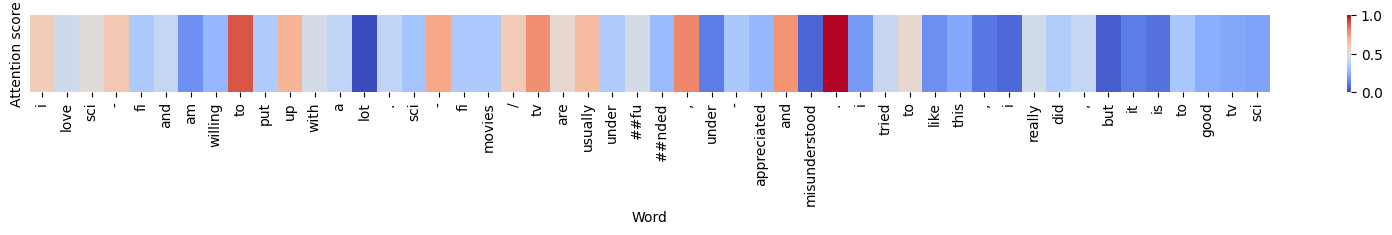

---------------------------------------------------------------------------------------------------------------------------------------------------

Text: its a totally average film with a few semi - alright action sequences that make the plot seem a little better and remind the viewer of the classic van dam films. parts of the plot don't make sense and seem to be added in to use up time. the end plot is that of a very basic type that doesn't leave the viewer guessing and any twists are obvious from the beginning. the end scene with the flask backs don't make sense as they are added in and seem to have little relevance to the history of van dam's character. not really worth watching again, bit disappointed in the end production, even though it is apparent it was shot on a low budget certain shots and sections in the film are of poor directed quality


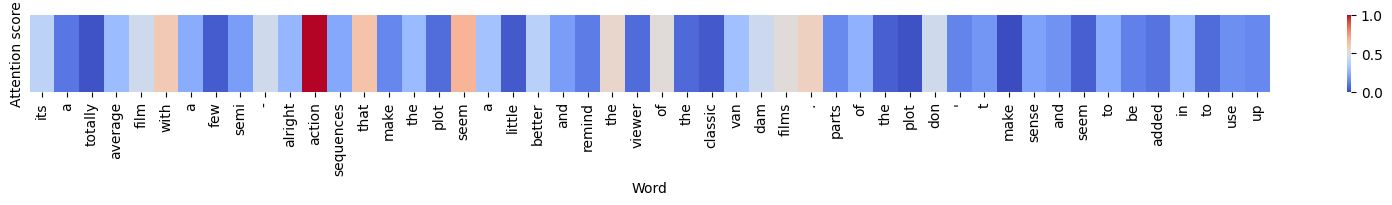

---------------------------------------------------------------------------------------------------------------------------------------------------

Text: i had high hopes for this one until they changed the name to'the shepherd : border patrol, the lamest movie name ever, what was wrong with just'the shepherd '. this is a by the numbers action flick that tips its hat at many classic van damme films. there is a nice bit of action in a bar which reminded me of hard target and universal soldier but directed with no intensity or flair which is a shame. there is one great line about'being p * ss drunk and carrying a rabbit'and some ok action scenes let down by the cheapness of it all. a lot of the times the dialogue doesn't match the characters mouth and the stunt men fall down dead a split second before even being shot. the end fight is one of the better van damme fights except the director tries to go a bit too john woo and fails also introducing flashbacks which no one really cares abou

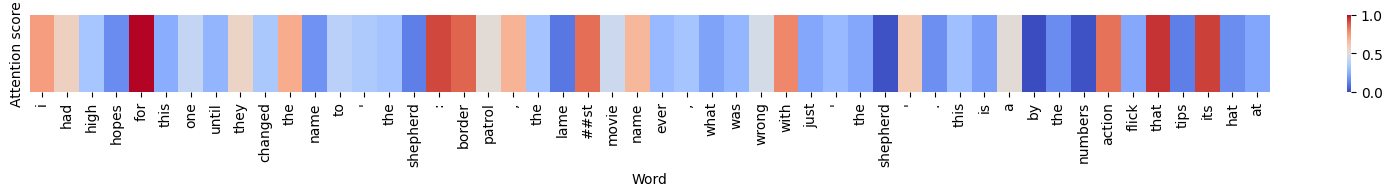

---------------------------------------------------------------------------------------------------------------------------------------------------

Text: isaac florentine has made some of the best western martial arts action movies ever produced. in particular us seals 2, cold harvest, special forces and undisputed 2 are all action classics. you can tell isaac has a real passion for the genre and his films are always eventful, creative and sharp affairs, with some of the best fight sequences an action fan could hope for. in particular he has found a muse with scott adkins, as talented an actor and action performer as you could hope for. this is borne out with special forces and undisputed 2, but unfortunately the shepherd just doesn't live up to their abilities. < br / > < br / > there is no doubt that jcvd looks better here fight - wise than he has done in years, especially in the fight he has ( for pretty much no reason ) in a prison cell, and in the final showdown with scott, but l

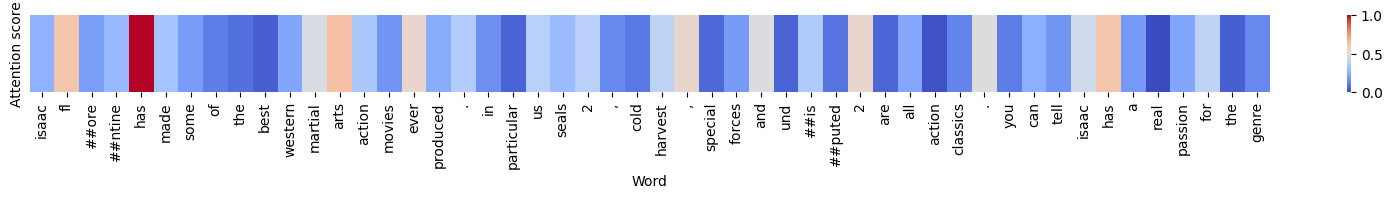

---------------------------------------------------------------------------------------------------------------------------------------------------

Text: it actually pains me to say it, but this movie was horrible on every level. the blame does not lie entirely with van damme as you can see he tried his best, but let's face it, he's almost fifty, how much more can you ask of him? i find it so hard to believe that the same people who put together undisputed 2 ; arguably the best ( western ) martial arts movie in years, created this. everything from the plot, to the dialog, to the editing, to the overall acting was just horribly put together and in many cases outright boring and nonsensical. scott adkins who's fight scenes seemed more like a demo reel, was also terribly underused and not even the main villain which is such a shame because 1 ) he is more than capable of playing that role and 2 ) the actual main villain was not only not intimidating at all but also quite annoying. again, 

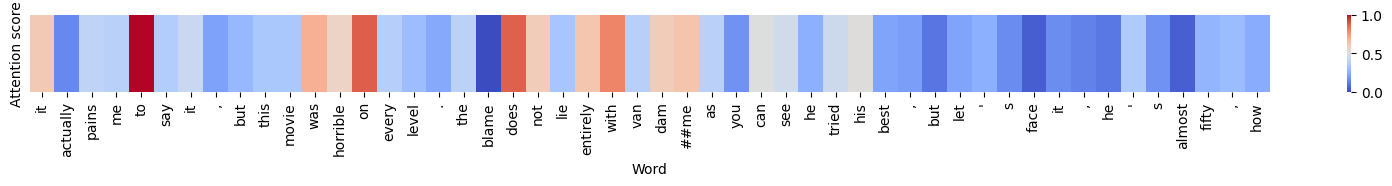

---------------------------------------------------------------------------------------------------------------------------------------------------

Incorrect predictions:
Text: worth the entertainment value of a rental, especially if you like action movies. this one features the usual car chases, fights with the great van damme kick style, shooting battles with the 40 shell load shotgun, and even terrorist style bombs. all of this is entertaining and competently handled but there is nothing that really blows you away if you've seen your share before. < br / > < br / > the plot is made interesting by the inclusion of a rabbit, which is clever but hardly profound. many of the characters are heavily stereotyped - - the angry veterans, the terrified illegal aliens, the crooked cops, the indifferent feds, the bitchy tough lady station head, the crooked politician, the fat federale who looks like he was typecast as the mexican in a hollywood movie from the 1940s. all passably acted but agai

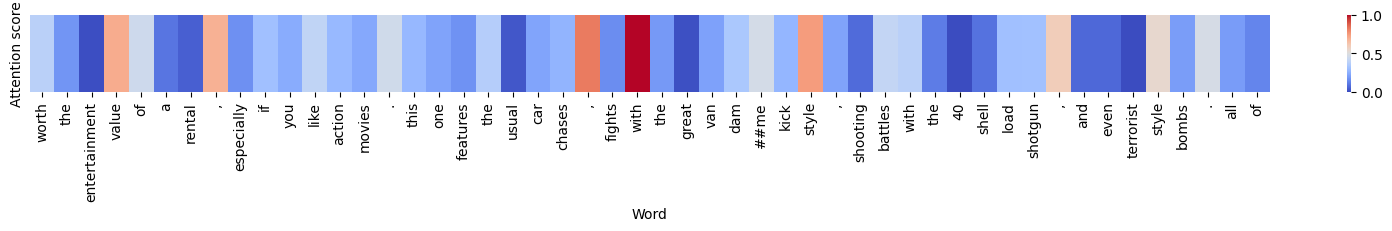

---------------------------------------------------------------------------------------------------------------------------------------------------

Text: star rating : * * * * * saturday night * * * * friday night * * * friday morning * * sunday night * monday morning < br / > < br / > former new orleans homicide cop jack robideaux ( jean claude van damme ) is re - assigned to columbus, a small but violent town in mexico to help the police there with their efforts to stop a major heroin smuggling operation into their town. the culprits turn out to be ex - military, lead by former commander benjamin meyers ( stephen lord, otherwise known as jase from east enders ) who is using a special method he learned in afghanistan to fight off his opponents. but jack has a more personal reason for taking him down, that draws the two men into an explosive final showdown where only one will walk away alive. < br / > < br / > after until death, van damme appeared to be on a high, showing he could mak

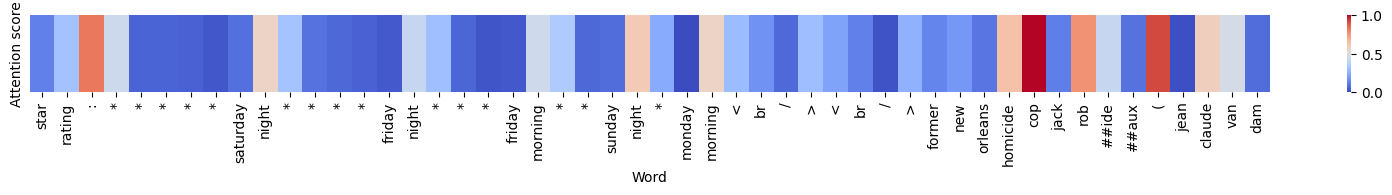

---------------------------------------------------------------------------------------------------------------------------------------------------

Text: first off let me say, if you haven't enjoyed a van damme movie since bloodsport, you probably will not like this movie. most of these movies may not have the best plots or best actors but i enjoy these kinds of movies for what they are. this movie is much better than any of the movies the other action guys ( segal and dolph ) have thought about putting out the past few years. van damme is good in the movie, the movie is only worth watching to van damme fans. it is not as good as wake of death ( which i highly recommend to anyone of likes van damme ) or in hell but, in my opinion it's worth watching. it has the same type of feel to it as nowhere to run. good fun stuff!


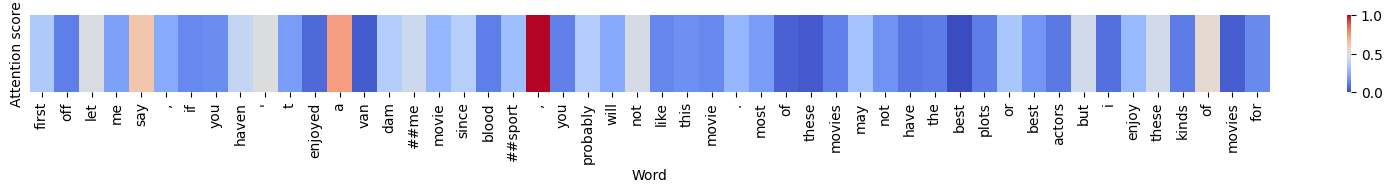

---------------------------------------------------------------------------------------------------------------------------------------------------

Text: ben, ( rupert grint ), is a deeply unhappy adolescent, the son of his unhappily married parents. his father, ( nicholas farrell ), is a vicar and his mother, ( laura linney ), is... well, let's just say she's a somewhat hypocritical soldier in jesus'army. it's only when he takes a summer job as an assistant to a foul - mouthed, eccentric, once - famous and now - forgotten actress evie walton, ( julie walters ), that he finally finds himself in true'harold and maude'fashion. of course, evie is deeply unhappy herself and it's only when these two sad sacks find each other that they can put their mutual misery aside and hit the road to happiness. < br / > < br / > of course it's corny and sentimental and very predictable but it has a hard side to it, too and walters, who could sleep - walk her way through this sort of thing if she wanted

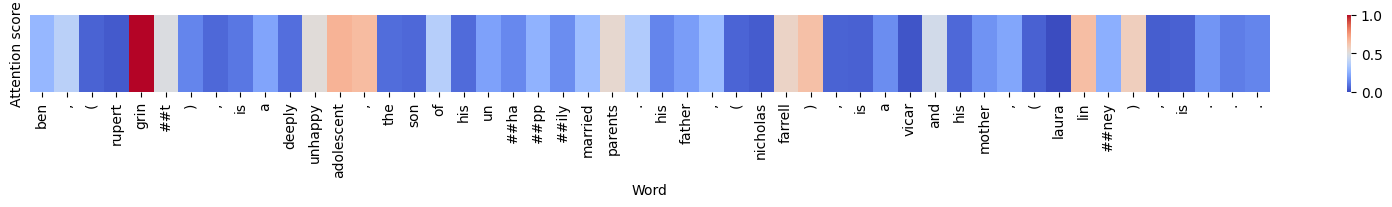

---------------------------------------------------------------------------------------------------------------------------------------------------

Text: low budget horror movie. if you don't raise your expectations too high, you'll probably enjoy this little flick. beginning and end are pretty good, middle drags at times and seems to go nowhere for long periods as we watch the goings on of the insane that add atmosphere but do not advance the plot. quite a bit of gore. i enjoyed bill mcghee's performance which he made quite believable for such a low budget picture, he managed to carry the movie at times when nothing much seemed to be happening. nurse charlotte beale, played by jesse lee, played her character well so be prepared to want to slap her toward the end! she makes some really stupid mistakes but then, that's what makes these low budget movies so good! i would have been out of that place and five states away long before she even considered that it might be a good idea to leav

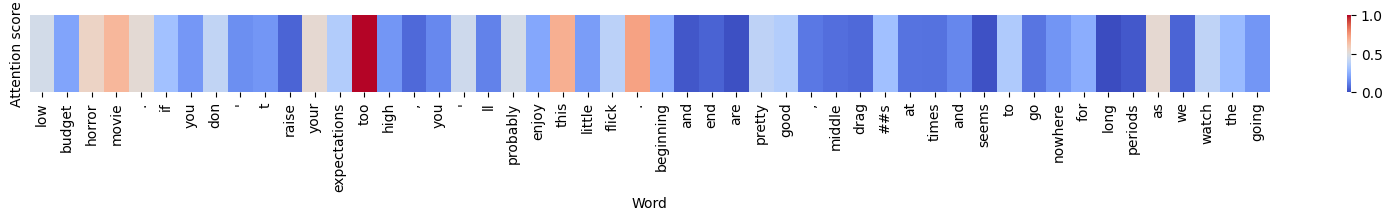

---------------------------------------------------------------------------------------------------------------------------------------------------



In [24]:
# Set the layer and head index for getting the attention scores
layer_idx = 0
head_idx = 0

print("Correct predictions:")
for example in correct_examples:
    print(f"Text: {example}")
    get_sequence(example, model, tokenizer, layer_idx, head_idx)

print("Incorrect predictions:")
for example in incorrect_examples:
    print(f"Text: {example}")
    get_sequence(example, model, tokenizer, layer_idx, head_idx)

## Attention matrix

In [26]:
def get_attention_matrix(text, model, tokenizer, layer_idx, head_idx):
    tokens = tokenizer.encode_plus(
        text,
        truncation=True,
        max_length=27,
        return_tensors="pt"
    )
    input_ids = tokens["input_ids"].to(device)
    attention_mask = tokens["attention_mask"].to(device)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)

    attentions = outputs.attentions[layer_idx][0, head_idx].cpu().numpy()

    tokens = tokenizer.tokenize(text)
    tokens = tokens[:25]
    tokens = ["[CLS]"] + tokens + ["[SEP]"]
    
    plt.figure(figsize=(10, 10))
    sns.heatmap(attentions, xticklabels=tokens, yticklabels=tokens, cmap='coolwarm')
    plt.show()


Correct predictions:
Text: i love sci - fi and am willing to put up with a lot. sci - fi movies / tv are usually underfunded, under - appreciated and misunderstood. i tried to like this, i really did, but it is to good tv sci - fi as babylon 5 is to star trek ( the original ). silly prosthetics, cheap cardboard sets, stilted dialogues, cg that doesn't match the background, and painfully one - dimensional characters cannot be overcome with a'sci - fi'setting. ( i'm sure there are those of you out there who think babylon 5 is good sci - fi tv. it's not. it's cliched and uninspiring. ) while us viewers might like emotion and character development, sci - fi is a genre that does not take itself seriously ( cf. star trek ). it may treat important issues, yet not as a serious philosophy. it's really difficult to care about the characters here as they are not simply foolish, just missing a spark of life. their actions and reactions are wooden and predictable, often painful to watch. the makers

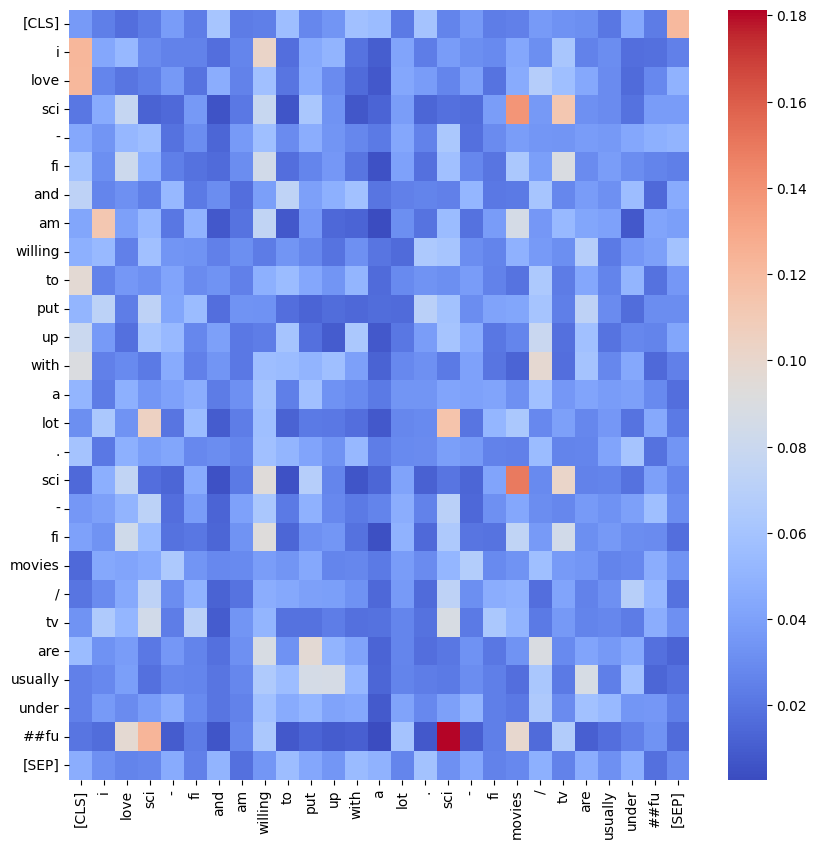

Text: its a totally average film with a few semi - alright action sequences that make the plot seem a little better and remind the viewer of the classic van dam films. parts of the plot don't make sense and seem to be added in to use up time. the end plot is that of a very basic type that doesn't leave the viewer guessing and any twists are obvious from the beginning. the end scene with the flask backs don't make sense as they are added in and seem to have little relevance to the history of van dam's character. not really worth watching again, bit disappointed in the end production, even though it is apparent it was shot on a low budget certain shots and sections in the film are of poor directed quality


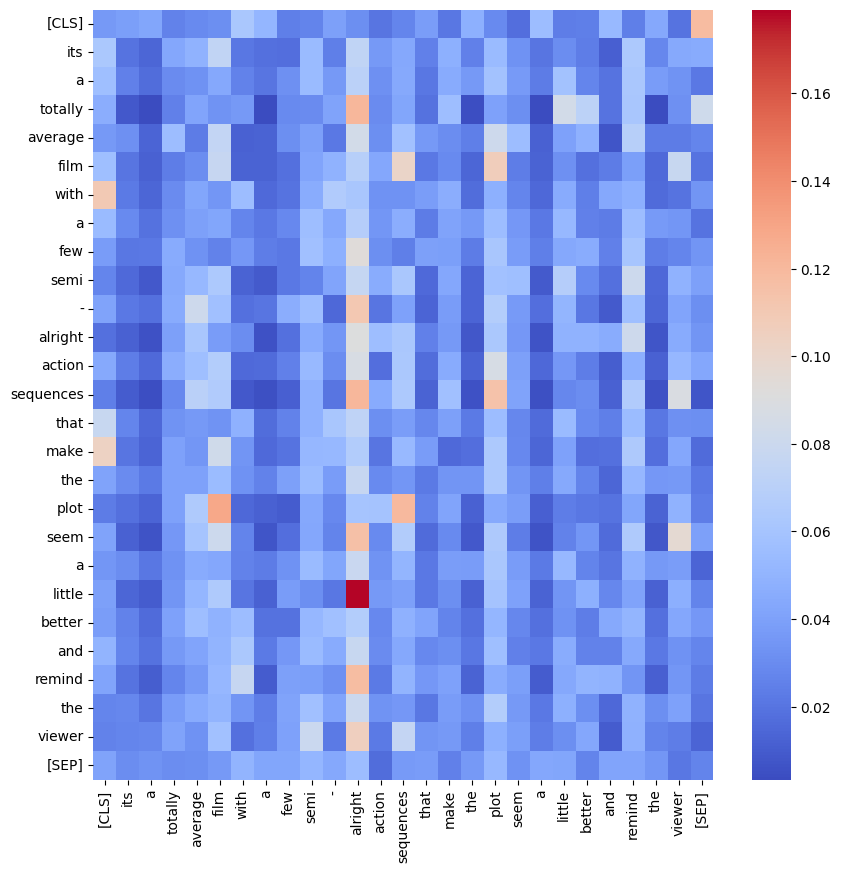

Text: i had high hopes for this one until they changed the name to'the shepherd : border patrol, the lamest movie name ever, what was wrong with just'the shepherd '. this is a by the numbers action flick that tips its hat at many classic van damme films. there is a nice bit of action in a bar which reminded me of hard target and universal soldier but directed with no intensity or flair which is a shame. there is one great line about'being p * ss drunk and carrying a rabbit'and some ok action scenes let down by the cheapness of it all. a lot of the times the dialogue doesn't match the characters mouth and the stunt men fall down dead a split second before even being shot. the end fight is one of the better van damme fights except the director tries to go a bit too john woo and fails also introducing flashbacks which no one really cares about just gets in the way of the action which is the whole point of a van damme film. < br / > < br / > not good, not bad, just average generic action.


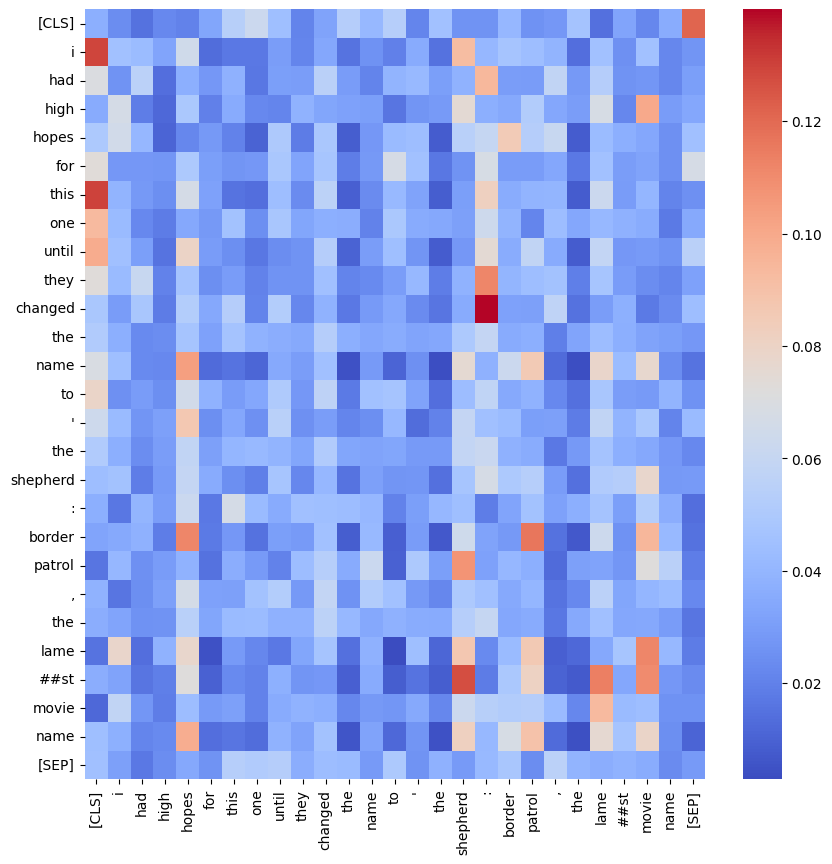

Text: isaac florentine has made some of the best western martial arts action movies ever produced. in particular us seals 2, cold harvest, special forces and undisputed 2 are all action classics. you can tell isaac has a real passion for the genre and his films are always eventful, creative and sharp affairs, with some of the best fight sequences an action fan could hope for. in particular he has found a muse with scott adkins, as talented an actor and action performer as you could hope for. this is borne out with special forces and undisputed 2, but unfortunately the shepherd just doesn't live up to their abilities. < br / > < br / > there is no doubt that jcvd looks better here fight - wise than he has done in years, especially in the fight he has ( for pretty much no reason ) in a prison cell, and in the final showdown with scott, but look in his eyes. jcvd seems to be dead inside. there's nothing in his eyes at all. it's like he just doesn't care about anything throughout the whole

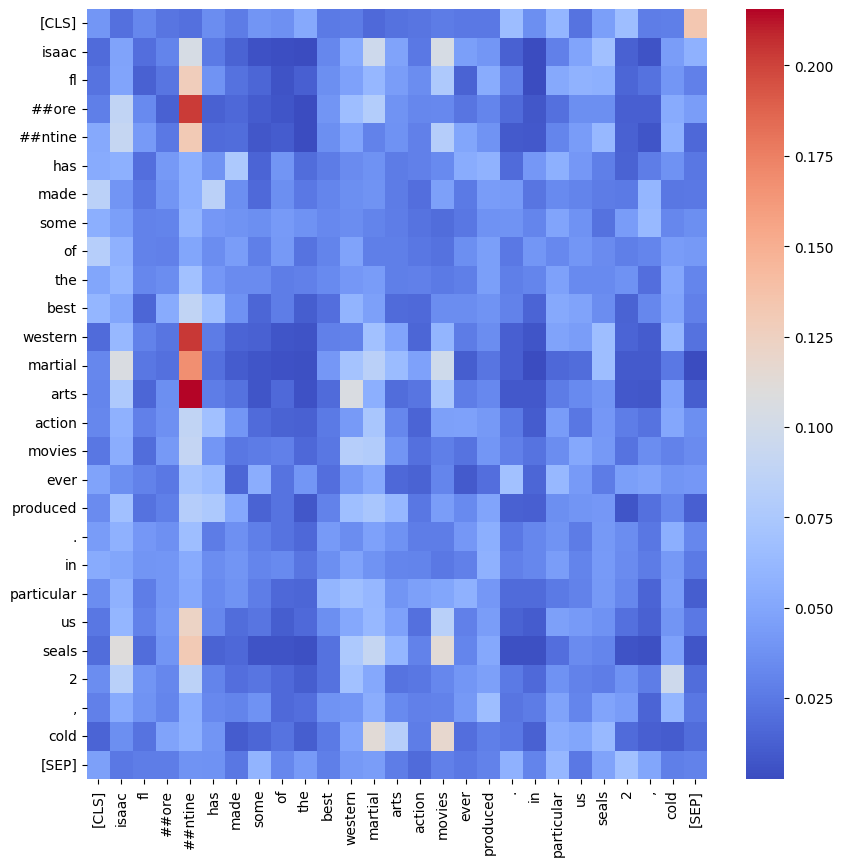

Text: it actually pains me to say it, but this movie was horrible on every level. the blame does not lie entirely with van damme as you can see he tried his best, but let's face it, he's almost fifty, how much more can you ask of him? i find it so hard to believe that the same people who put together undisputed 2 ; arguably the best ( western ) martial arts movie in years, created this. everything from the plot, to the dialog, to the editing, to the overall acting was just horribly put together and in many cases outright boring and nonsensical. scott adkins who's fight scenes seemed more like a demo reel, was also terribly underused and not even the main villain which is such a shame because 1 ) he is more than capable of playing that role and 2 ) the actual main villain was not only not intimidating at all but also quite annoying. again, not blaming van damme. i will always be a fan, but avoid this one.


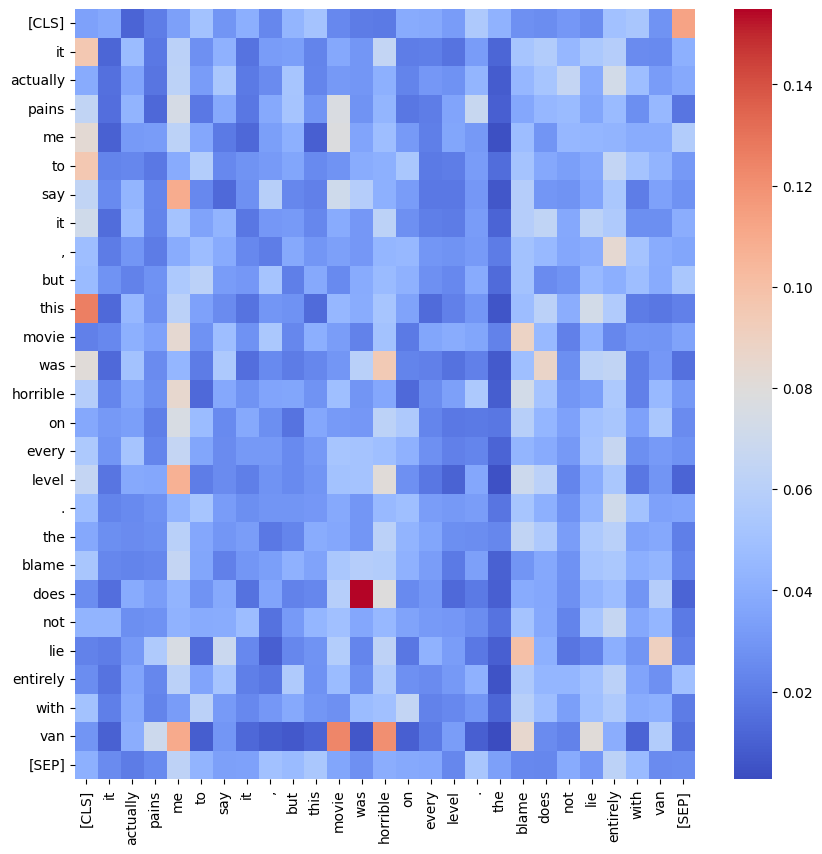

Incorrect predictions:
Text: worth the entertainment value of a rental, especially if you like action movies. this one features the usual car chases, fights with the great van damme kick style, shooting battles with the 40 shell load shotgun, and even terrorist style bombs. all of this is entertaining and competently handled but there is nothing that really blows you away if you've seen your share before. < br / > < br / > the plot is made interesting by the inclusion of a rabbit, which is clever but hardly profound. many of the characters are heavily stereotyped - - the angry veterans, the terrified illegal aliens, the crooked cops, the indifferent feds, the bitchy tough lady station head, the crooked politician, the fat federale who looks like he was typecast as the mexican in a hollywood movie from the 1940s. all passably acted but again nothing special. < br / > < br / > i thought the main villains were pretty well done and fairly well acted. by the end of the movie you certainly k

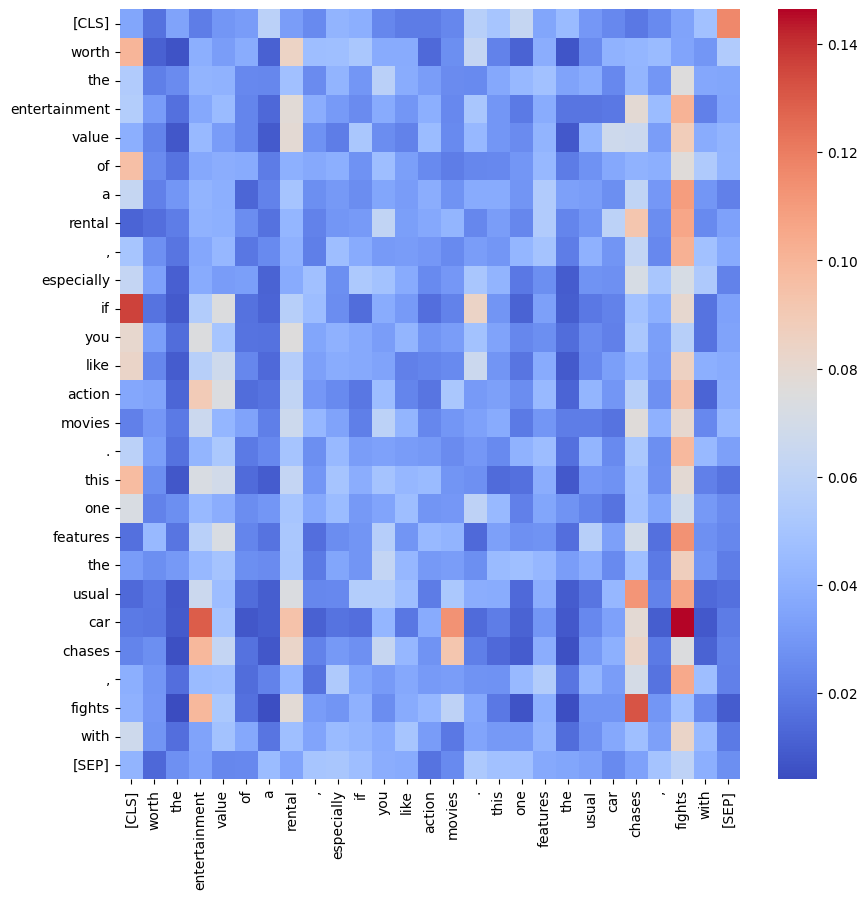

Text: star rating : * * * * * saturday night * * * * friday night * * * friday morning * * sunday night * monday morning < br / > < br / > former new orleans homicide cop jack robideaux ( jean claude van damme ) is re - assigned to columbus, a small but violent town in mexico to help the police there with their efforts to stop a major heroin smuggling operation into their town. the culprits turn out to be ex - military, lead by former commander benjamin meyers ( stephen lord, otherwise known as jase from east enders ) who is using a special method he learned in afghanistan to fight off his opponents. but jack has a more personal reason for taking him down, that draws the two men into an explosive final showdown where only one will walk away alive. < br / > < br / > after until death, van damme appeared to be on a high, showing he could make the best straight to video films in the action market. while that was a far more drama oriented film, with the shepherd he has returned to the high

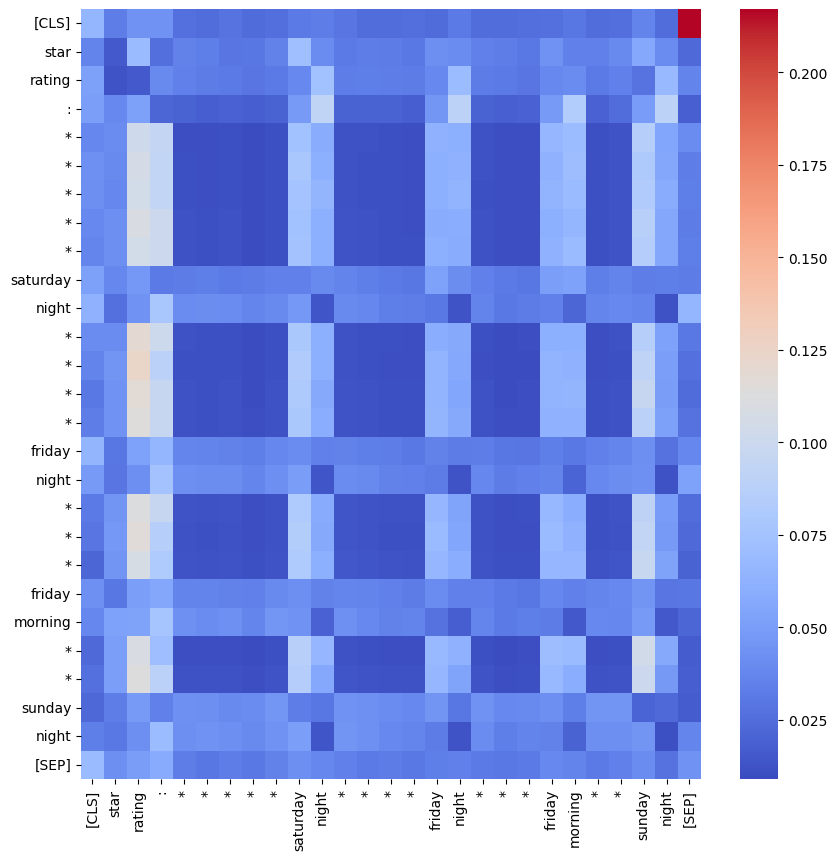

Text: first off let me say, if you haven't enjoyed a van damme movie since bloodsport, you probably will not like this movie. most of these movies may not have the best plots or best actors but i enjoy these kinds of movies for what they are. this movie is much better than any of the movies the other action guys ( segal and dolph ) have thought about putting out the past few years. van damme is good in the movie, the movie is only worth watching to van damme fans. it is not as good as wake of death ( which i highly recommend to anyone of likes van damme ) or in hell but, in my opinion it's worth watching. it has the same type of feel to it as nowhere to run. good fun stuff!


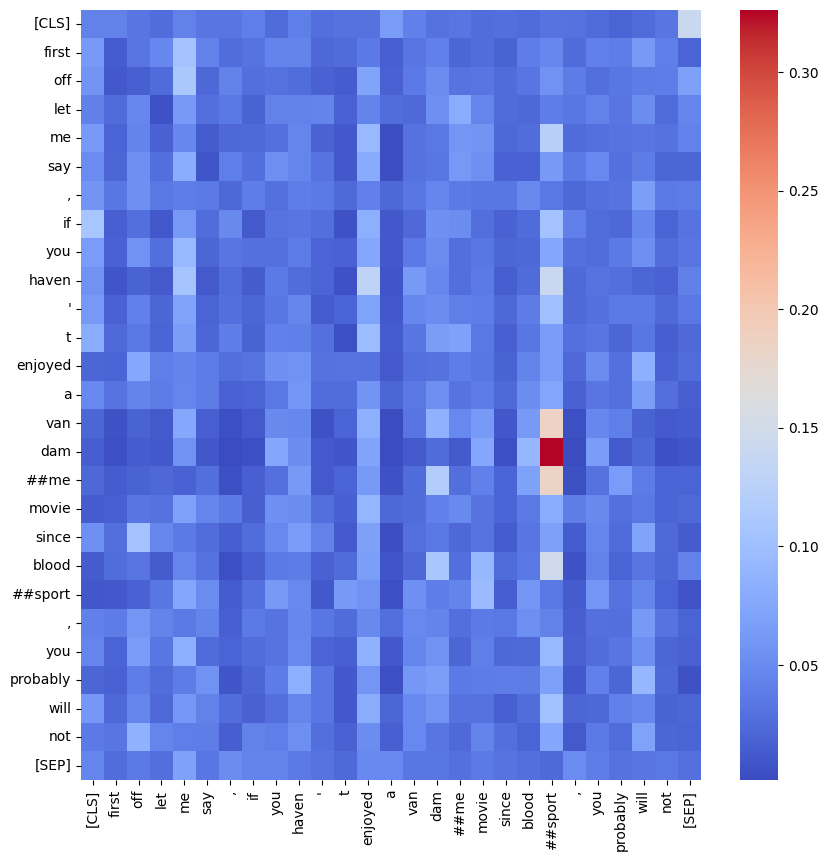

Text: ben, ( rupert grint ), is a deeply unhappy adolescent, the son of his unhappily married parents. his father, ( nicholas farrell ), is a vicar and his mother, ( laura linney ), is... well, let's just say she's a somewhat hypocritical soldier in jesus'army. it's only when he takes a summer job as an assistant to a foul - mouthed, eccentric, once - famous and now - forgotten actress evie walton, ( julie walters ), that he finally finds himself in true'harold and maude'fashion. of course, evie is deeply unhappy herself and it's only when these two sad sacks find each other that they can put their mutual misery aside and hit the road to happiness. < br / > < br / > of course it's corny and sentimental and very predictable but it has a hard side to it, too and walters, who could sleep - walk her way through this sort of thing if she wanted, is excellent. it's when she puts the craziness to one side and finds the pathos in the character, ( like hitting the bottle and throwing up in the 

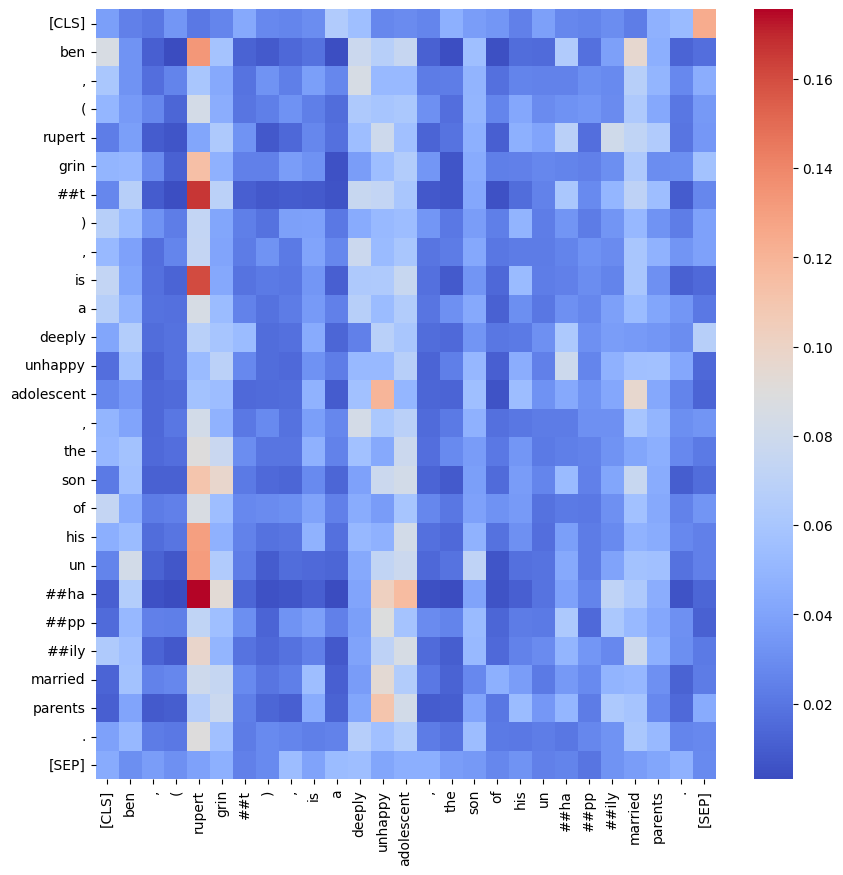

Text: low budget horror movie. if you don't raise your expectations too high, you'll probably enjoy this little flick. beginning and end are pretty good, middle drags at times and seems to go nowhere for long periods as we watch the goings on of the insane that add atmosphere but do not advance the plot. quite a bit of gore. i enjoyed bill mcghee's performance which he made quite believable for such a low budget picture, he managed to carry the movie at times when nothing much seemed to be happening. nurse charlotte beale, played by jesse lee, played her character well so be prepared to want to slap her toward the end! she makes some really stupid mistakes but then, that's what makes these low budget movies so good! i would have been out of that place and five states away long before she even considered that it might be a good idea to leave! if you enjoy this movie, try committed from 1988 which is basically a rip off of this movie.


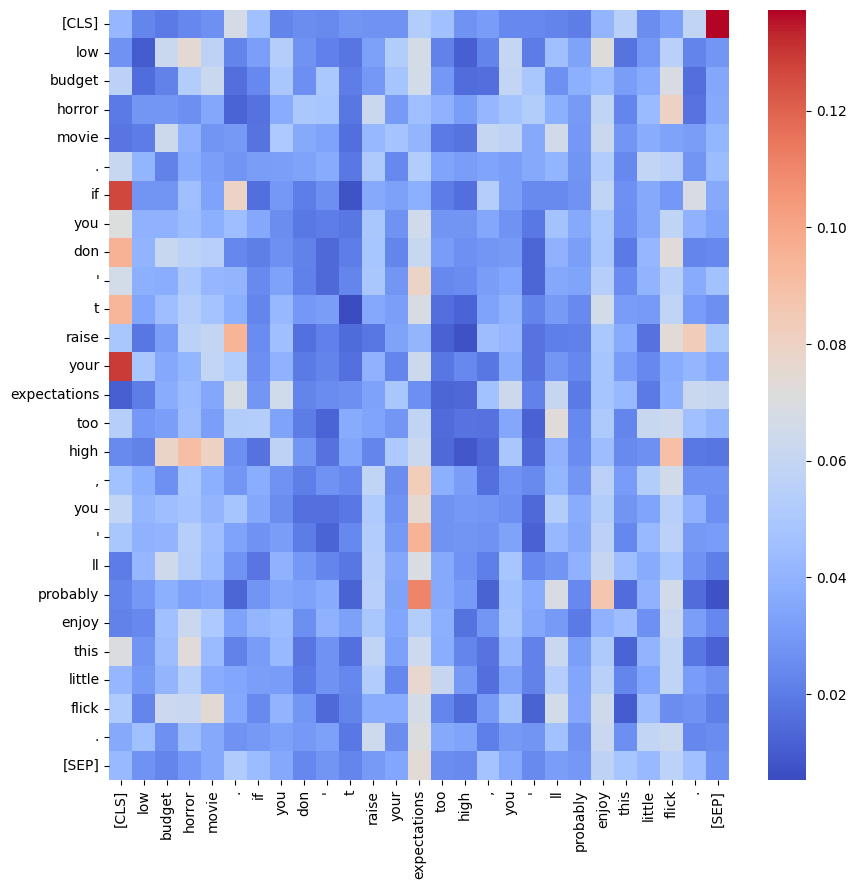

In [27]:
layer_idx = 0
head_idx = 0

print("Correct predictions:")
for example in correct_examples:
    print(f"Text: {example}")
    get_attention_matrix(example, model, tokenizer, layer_idx, head_idx)

print("Incorrect predictions:")
for example in incorrect_examples:
    print(f"Text: {example}")
    get_attention_matrix(example, model, tokenizer, layer_idx, head_idx)

Loss over iterations

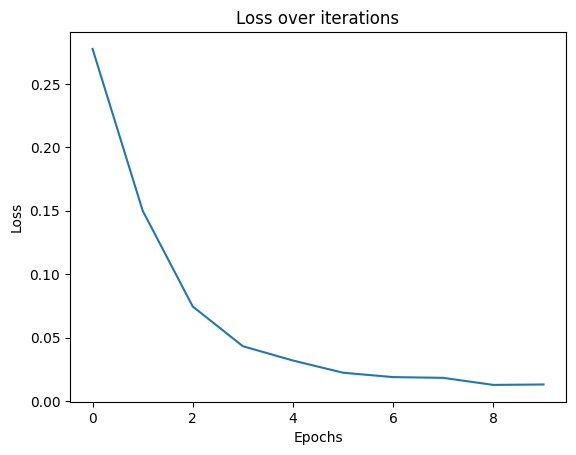

In [21]:
plt.plot(loss_list)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over iterations')
plt.show()